# Bonus1: Parallel Algorithms

### Name: Tara Lozy


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [20]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [21]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [22]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.00607193  0.04195117 -0.05066401 -0.00098118  0.07385478  0.05142506
   0.039565   -0.08846857]]
test std = 
[[1.03894877 0.89011585 1.11280051 1.00640758 0.94814286 0.95235565
  1.00601508 0.88889714]]


## 1.4. Add a dimension of all ones

In [23]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## 1.5 Create Worker Node 

In [24]:
class Worker: 
    def __init__(self, x, y):
        self.x = x # s-by-d local feature matrix
        self.y = y # s-by-1 local label matrix 
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features 
        self.w = numpy.zeros((d, 1)) # d-by-1 model parameter vector 
        self.a = 0.9 # learning rate
    
    # Set the model parameters to the latest 
    def set_param(self, w):
        self.w = w
  
    # Compute the local objective function
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d matrix
        yxw = numpy.dot(yx, self.w) #s-by-1 matrix
        vec1 = numpy.exp(-yxw) #s-by-1 matrix
        vec2 = numpy.log(1 + vec1) # s-by-1 matrix
        return numpy.sum(vec2) # loss function 
    
    # Compute the local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d matrix
        yxw = numpy.dot(yx, self.w) # s-by-1 matrix
        vec1 = numpy.exp(yxw) # s-by-1 matrix
        vec2 = numpy.divide(yx, 1+vec1) # s-by-d matrix
        g = -numpy.sum(vec2, axis = 0).reshape(self.d, 1) # d-by-1 matrix
        return g
        
    def gd(self):  #update model parameters using gradient descent
        self.w -= self.a * self.g   #alpha is learning rate 
    

## 1.6 Create Server Node

In [25]:
class Server: 
    def __init__(self, m, n, d):
        self.m = m # number of worker nodes
        self.n = n # number of training samples
        self.d = d # number of features
        self.w = numpy.zeros((d, 1)) # d-by-1 model parameter vector
        self.g = numpy.zeros((d, 1)) # d-by-1 gradient
        self.loss = 0 # loss function value
        self.obj = 0 # objective function value 

        
    def broadcast(self):
        return self.w
    
    def aggregate(self, grads, losses): 
        self.g = numpy.zeros((self.d, 1))
        self.loss = 0
        for k in range(self.m):
            self.g += grads[k] # list of d-by-1 vectors
            self.loss += losses[k] # list of scalers
            
        self.g /= self.m  # average the gradient 
        #self.loss /= self.m  # average the loss
    
    def gradient(self, lam):
        self.g = self.g / self.n + lam * self.w #compute the gradient
    
    def objective(self, lam): # compute the objective function 
        reg = lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss / self.n + reg
        return self.obj  
    
    def gd(self, alpha):  #update model parameters using gradient descent 
        self.w -= alpha * self.g   #alpha is learning rate 

## 1.7 Initialization

In [26]:
import math

def create_server_workers(m, x, y): # create a server and m worker nodes
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d)
    workers = []
    
    for i in range(m):
        indices = list(range(i * s, (i + 1) * s))
        worker = Worker(x[indices, :], y[indices, :])
        workers.append(worker)
        
    return server, workers

In [27]:
m = 4 # number of worker nodes 
server , workers = create_server_workers(m, x_train, y_train)

## 1.8 K-fold Validation to tune parameters

In [24]:
# stepsize parameter tuning using k-fold cross validation
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

C_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2]  #step parameters

for value in C_values:
    kf10 = KFold(n_splits=10, shuffle=True)   #split data into 10 folds
    model = LogisticRegression(C=value)    #use regression for model

    results = cross_val_score(model, x_train, numpy.ravel(y_train), cv = kf10, scoring='accuracy') # check accuracy scores
    print("P Value :", value, (results.mean()*100.0, results.std()*100.0))

P Value : 0.1 (76.875, 3.2625957840345463)
P Value : 0.2 (76.09375, 6.053553321190787)
P Value : 0.3 (76.09375, 3.766240872873109)
P Value : 0.4 (76.71875, 5.522061577210091)
P Value : 0.5 (76.40625, 4.606063429057398)
P Value : 0.6 (76.875, 4.2961647140211)
P Value : 0.7 (76.5625, 3.045873232752801)
P Value : 0.8 (76.875, 5.448623679425841)
P Value : 0.9 (77.1875, 5.284854539152426)
P Value : 1 (76.40625, 4.813413062734176)
P Value : 1.5 (76.71875, 3.6610545355812443)
P Value : 2 (76.875, 4.0625)


I will use stepsize = 0.9 since it has the largest accuracy. 

## 1.9 Performing Parallel GD, q = 1

In [28]:
lam = 1E-6 # regularization parameter
alpha = 0.9 # learning rate
max_epoch = 100 # number of epochs 
objvals = numpy.zeros(max_epoch) # to store objective function 

for t in range(max_epoch):
    
    w = server.broadcast() # broadcast to worker nodes
    objval = 0 # accumulate the objective values
    for i in range(m):
        workers[i].set_param(w)
    
    # workers' local computation 
    grads = []
    losses = []
    for i in range(m):
        g = workers[i].gradient()
        grads.append(g)
        l = workers[i].loss()
        losses.append(l)
        
    server.aggregate(grads, losses) # aggregate the worker's outputs
    
    #update the server with the model parameters
    server.gradient(lam) # compute gradient
    obj = server.objective(lam) # compute objective function
    objvals[t] = obj
    print('Objective function value = ' + str(obj))
    server.gd(alpha) # updates the model parameters 

Objective function value = 0.6931471805599453
Objective function value = 0.6633377003791222
Objective function value = 0.6388262690792416
Objective function value = 0.6185053640989308
Objective function value = 0.601494852181197
Objective function value = 0.5871109399474408
Objective function value = 0.5748271360979651
Objective function value = 0.5642382527495621
Objective function value = 0.5550310223440084
Objective function value = 0.5469614454329712
Objective function value = 0.5398377892125714
Objective function value = 0.5335079649608194
Objective function value = 0.5278501753985786
Objective function value = 0.5227659641425471
Objective function value = 0.5181750202228723
Objective function value = 0.5140112658751677
Objective function value = 0.510219886643145
Objective function value = 0.5067550577576528
Objective function value = 0.5035781887827304
Objective function value = 0.5006565570751335
Objective function value = 0.49796223529909944
Objective function value = 0.495471

## 1.10 Performing Parallel GD, q = 8

In [29]:
m = 4 # number of worker nodes 
server , workers = create_server_workers(m, x_train, y_train)

In [30]:
lam = 1E-6 # regularization parameter
alpha = 0.9 # learning rate
max_epoch = 100 # number of epochs 
objvals_2 = numpy.zeros(max_epoch) # to store objective function 
q = 8 # number of local iterations 

for t in range(max_epoch):
    
    w = server.broadcast() # broadcast to worker nodes
    objval_2 = 0 # accumulate the objective values
    for i in range(m):
        workers[i].set_param(w)
    
    # workers' local computation 
    grads = []
    losses = []
    for i in range(m):
        for h in range(q):
            g = workers[i].gradient()
            grads.append(g)
            l = workers[i].loss()
            losses.append(l)
        
    server.aggregate(grads, losses) # aggregate the worker's outputs
    
    #update the server with the model parameters
    server.gradient(lam) # compute gradient
    obj = server.objective(lam) # compute objective function
    objvals_2[t] = obj 
    print('Objective function value = ' + str(obj))
    server.gd(alpha) # updates the model parameters 

Objective function value = 0.6931471805599453
Objective function value = 0.6621782528716706
Objective function value = 0.6376442499295994
Objective function value = 0.6178979017411662
Objective function value = 0.6017295188386217
Objective function value = 0.5882716458471416
Objective function value = 0.5769029894297527
Objective function value = 0.5671739163448097
Objective function value = 0.5587539160919472
Objective function value = 0.5513957947884081
Objective function value = 0.5449114375664496
Objective function value = 0.5391553004721471
Objective function value = 0.5340130282293786
Objective function value = 0.5293934886300438
Objective function value = 0.5252231097695579
Objective function value = 0.5214417911119056
Objective function value = 0.517999906280184
Objective function value = 0.5148560745701585
Objective function value = 0.5119754816953869
Objective function value = 0.5093285984512711
Objective function value = 0.5068901915024705
Objective function value = 0.504638

## 1.11 Performing Parallel SGD with q=1

In [31]:
class Worker_SGD: 
    def __init__(self, x, y):
        self.x = x # s-by-d local feature matrix
        self.y = y # s-by-1 local label matrix 
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features 
        self.w = numpy.zeros((d, 1)) # d-by-1 model parameter vector 
        self.a = 0.9 # learning rate
    
    # Set the model parameters to the latest 
    def set_param(self, w):
        self.w = w
  
    # Compute the local objective function
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d matrix
        yxw = numpy.dot(yx, self.w) #s-by-1 matrix
        vec1 = numpy.exp(-yxw) #s-by-1 matrix
        vec2 = numpy.log(1 + vec1) # s-by-1 matrix
        return numpy.sum(vec2) # loss function 
    
    # Compute the local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d matrix
        yxw = numpy.dot(yx, self.w) # s-by-1 matrix
        vec1 = numpy.exp(yxw) # s-by-1 matrix
        vec2 = numpy.divide(yx, 1+vec1) # s-by-d matrix
        g = -numpy.sum(vec2, axis = 0).reshape(self.d, 1) # d-by-1 matrix
        return g
        
    def gd(self):  #update model parameters using gradient descent
        self.w -= self.a * self.g   #alpha is learning rate

In [40]:
import math

class Server_SGD: 
    def __init__(self, m, n, d):
        self.m = m # number of worker nodes
        self.n = n # number of training samples
        self.d = d # number of features
        self.w = numpy.zeros((d, 1)) # d-by-1 model parameter vector
        self.g = numpy.zeros((d, 1)) # d-by-1 gradient
        self.loss = 0 # loss function value
        self.obj = 0 # objective function value 
        self.s = math.floor(n / m)

        
    def broadcast(self):
        return self.w
    
    def aggregate(self, grads, losses): 
        self.g = numpy.zeros((self.d, 1))
        self.loss = 0
        for k in range(self.m):
            self.g += grads[k] # list of d-by-1 vectors
            self.loss += losses[k] # list of scalers
            
        self.g /= self.m  # average the gradient 
        #self.loss /= self.m  # average the loss
    
    def gradient(self, lam):
        self.g = self.g / self.s + lam * self.w #compute the gradient
    
    def objective(self, lam): # compute the objective function 
        reg = lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss / self.n + reg
        return self.obj  
    
    def gd(self, alpha):  #update model parameters using gradient descent 
        self.w -= alpha * self.g   #alpha is learning rate

In [33]:
import math

def create_server_workers_sgd(m, x, y): # create a server and m worker nodes
    n, d = x.shape
    s = math.floor(n / m)
    server_sgd = Server_SGD(m, n, d)
    workers_sgd = []
    
    # randomly shuffle the samples
    rand_indices = numpy.random.permutation(n)
    
    for i in range(m):
        indices = list(range(i * s, (i + 1) * s))
        for b in range(s):
            rand_indices = indices 
            worker_sgd = Worker_SGD(x[rand_indices, :], y[rand_indices, :])
            workers_sgd.append(worker_sgd)
        
    return server_sgd, workers_sgd

In [41]:
m = 4 # number of worker nodes 
server_sgd , workers_sgd = create_server_workers_sgd(m, x_train, y_train)

In [42]:
lam = 1E-6 # regularization parameter
alpha = 0.9 # learning rate
max_epoch = 100 # number of epochs 
objvals_3 = numpy.zeros(max_epoch) # to store objective function 
q = 1 # number of local iterations 

for t in range(max_epoch):
   
    w = server_sgd.broadcast() # broadcast to worker nodes
    objval_3 = 0 # accumulate the objective values
    for i in range(m):
        workers_sgd[i].set_param(w)
    
    # workers' local computation 
    grads = []
    losses = []
    for i in range(m):
        for h in range(q):
            g = workers_sgd[i].gradient()
            grads.append(g)
            l = workers_sgd[i].loss()
            losses.append(l)
        
    server_sgd.aggregate(grads, losses) # aggregate the worker's outputs
    
    #update the server with the model parameters
    server_sgd.gradient(lam) # compute gradient
    obj = server_sgd.objective(lam) # compute objective function
    objvals_3[t] = obj
    print('Objective function value = ' + str(obj))
    server_sgd.gd(alpha) # updates the model parameters 

Objective function value = 0.6931471805599453
Objective function value = 0.5905966978034993
Objective function value = 0.5504096753368399
Objective function value = 0.5279029366193363
Objective function value = 0.5133447871864237
Objective function value = 0.5032251332923876
Objective function value = 0.49587673686130856
Objective function value = 0.49037743970925773
Objective function value = 0.48616755861210564
Objective function value = 0.4828859934850302
Objective function value = 0.48028950876135806
Objective function value = 0.47820887996255584
Objective function value = 0.47652332434670236
Objective function value = 0.47514479409960586
Objective function value = 0.47400793745148023
Objective function value = 0.4730634790022182
Objective function value = 0.4722737423620771
Objective function value = 0.47160955643862396
Objective function value = 0.4710480779920415
Objective function value = 0.4705712339208714
Objective function value = 0.47016459046239
Objective function value = 

In [43]:
m = 4 # number of worker nodes 
server_sgd , workers_sgd = create_server_workers_sgd(m, x_train, y_train)

In [44]:
lam = 1E-6 # regularization parameter
alpha = 0.9 # learning rate
max_epoch = 100 # number of epochs 
objvals_4 = numpy.zeros(max_epoch) # to store objective function 
q = 8 # number of local iterations 

for t in range(max_epoch):
   
    w = server_sgd.broadcast() # broadcast to worker nodes
    objval_4 = 0 # accumulate the objective values
    for i in range(m):
        workers_sgd[i].set_param(w)
    
    # workers' local computation 
    grads = []
    losses = []
    for i in range(m):
        for h in range(q):
            g = workers_sgd[i].gradient()
            grads.append(g)
            l = workers_sgd[i].loss()
            losses.append(l)
        
    server_sgd.aggregate(grads, losses) # aggregate the worker's outputs
    
    #update the server with the model parameters
    server_sgd.gradient(lam) # compute gradient
    obj = server_sgd.objective(lam) # compute objective function
    objvals_4[t] = obj
    print('Objective function value = ' + str(obj))
    server_sgd.gd(alpha) # updates the model parameters 

Objective function value = 0.6931471805599453
Objective function value = 0.5905966978034993
Objective function value = 0.5504096753368399
Objective function value = 0.5279029366193363
Objective function value = 0.5133447871864237
Objective function value = 0.5032251332923876
Objective function value = 0.49587673686130856
Objective function value = 0.49037743970925773
Objective function value = 0.48616755861210564
Objective function value = 0.4828859934850302
Objective function value = 0.48028950876135806
Objective function value = 0.47820887996255584
Objective function value = 0.47652332434670236
Objective function value = 0.47514479409960586
Objective function value = 0.47400793745148023
Objective function value = 0.4730634790022182
Objective function value = 0.4722737423620771
Objective function value = 0.47160955643862396
Objective function value = 0.4710480779920415
Objective function value = 0.4705712339208714
Objective function value = 0.47016459046239
Objective function value = 

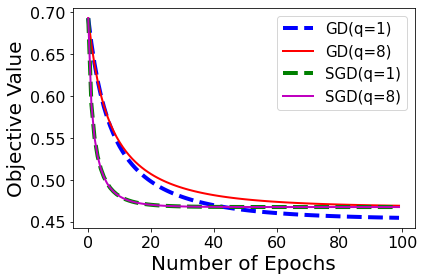

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals))

line0, = plt.plot(epochs_gd, objvals, '--b', lw=4)
line1, = plt.plot(epochs_gd, objvals_2, '-r', lw=2)
line2, = plt.plot(epochs_gd, objvals_3, '--g', lw=4)
line3, = plt.plot(epochs_gd, objvals_4, '-m', lw=2)
plt.xlabel('Number of Epochs', size=20)
plt.ylabel('Objective Value', size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend([line0, line1, line2, line3], ['GD(q=1)', 'GD(q=8)', 'SGD(q=1)', 'SGD(q=8)'], fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)